In [1]:
import hcipy
from hcipy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 100

In [2]:
def make_iris_aperture(normalized=False, with_spiders=False, with_segment_gaps=False, gap_padding=0, segment_transmissions=1, return_header=False, return_segments=False):
    pupil_diameter = 4.242 #mm actual circumscribed diameter, used for lam/D calculations other measurements normalized by this diameter
    actual_segment_flat_diameter = np.sqrt(3)/2 * .7  #mm actual segment flat-to-flat diameter
    actual_segment_gap = 0.001 #mm actual gap size between segments
    spider_width = 1*0.00850 #mm actual strut size
    gap_padding = 10.
    segment_gap = actual_segment_gap * gap_padding #padding out the segmentation gaps so they are visible and not sub-pixel
    segment_transmissions = 1.

    segment_flat_diameter = actual_segment_flat_diameter - (segment_gap - actual_segment_gap)
    segment_circum_diameter = 2 / np.sqrt(3) * segment_flat_diameter #segment circumscribed diameter

    num_rings = 3 #number of full rings of hexagons around central segment

    segment_positions = make_hexagonal_grid(actual_segment_flat_diameter + actual_segment_gap, num_rings)
    segment_positions = segment_positions.subset(lambda grid: ~(circular_aperture(segment_circum_diameter)(grid) > 0))

    segment = hexagonal_aperture(segment_circum_diameter, np.pi / 2)

    spider1 = make_spider_infinite([0, 0], 0, spider_width) # origin, degree, width 
    spider2 = make_spider_infinite([0, 0], 60, spider_width) 
    spider3 = make_spider_infinite([0, 0], 120, spider_width)
    spider4 = make_spider_infinite([0, 0], 180, spider_width)
    spider5 = make_spider_infinite([0, 0], 240, spider_width)
    spider6 = make_spider_infinite([0, 0], 300, spider_width)

    segmented_aperture = make_segmented_aperture(segment, segment_positions, segment_transmissions, return_segments=return_segments)
    
    def func(grid):
        res = segmented_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid)* spider4(grid) * spider3(grid)* spider5(grid) * spider6(grid) # * coro(grid)
        return Field(res, grid)
    
    return func


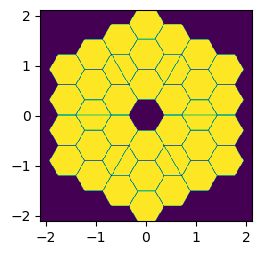

In [3]:
telescope_diameter = 4.242
num_pupil_pixels = 240 
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, telescope_diameter)
focal_grid = make_focal_grid(6, 10)  


iris_aperture = evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid, 6)

plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.subplot(1, 2, 2)
imshow_field(iris_aperture)
plt.show()

# Get rid of spiders???

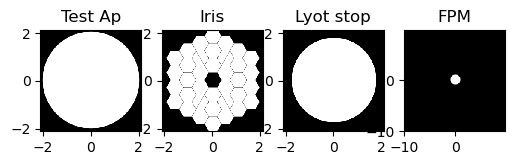

In [9]:
lyot_mask = evaluate_supersampled(circular_aperture(3.5), pupil_grid, 6)
test_aperture = evaluate_supersampled(circular_aperture(4), pupil_grid, 6)
fpm_inverse = evaluate_supersampled(circular_aperture(2), focal_grid, 6)
t = np.array(fpm_inverse)
fpm = Field(np.array(t ==0, dtype=int), fpm_inverse.grid)
plt.subplot(1, 4, 1)
plt.title('Test Ap')
imshow_field(test_aperture, cmap='gray')
plt.subplot(1,4,2)
plt.title('Iris')
imshow_field(iris_aperture, cmap='gray')
plt.subplot(1,4,3)
plt.title('Lyot stop')
imshow_field(lyot_mask, cmap='gray')
plt.subplot(1, 4, 4)
plt.title('FPM')
imshow_field(fpm_inverse, cmap='gray')
plt.show()

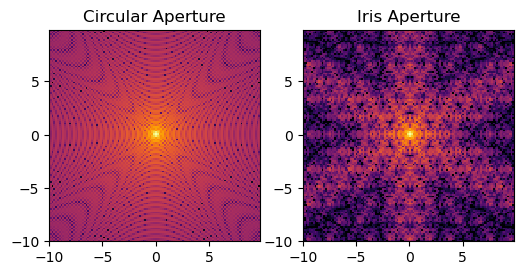

In [11]:
prop = FraunhoferPropagator(pupil_grid, focal_grid)

wf = Wavefront(test_aperture)
img_ref = prop(wf).intensity

wf_iris = Wavefront(iris_aperture)
img_ref_iris = prop(wf_iris).intensity



plt.subplot(1, 2, 1)
plt.title('Circular Aperture')
imshow_field(np.log10(img_ref), cmap='inferno')
plt.subplot(1, 2, 2)
plt.title('Iris Aperture')
imshow_field(np.log10(img_ref_iris / img_ref_iris.max()), vmin=-9, cmap='inferno')
#plt.subplot(1, 3, 3)
#plt.title('Aperture x 3')
#imshow_field(np.log10(img_ref_big / img_ref_big.max()), vmin=-9, cmap='inferno')

plt.show()

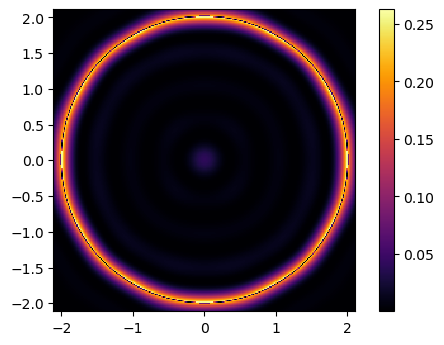

In [12]:
l_coro = LyotCoronagraph(pupil_grid, fpm)
lyot_stop = Apodizer(lyot_mask)

wf = Wavefront(iris_aperture)
wf_reg = Wavefront(test_aperture)
lyot_plane = l_coro(wf)
lyot_plane_test = l_coro(wf_reg)

#imshow_field(lyot_plane.intensity, cmap='inferno')
imshow_field(lyot_plane_test.intensity, cmap='inferno')
plt.colorbar()
plt.show()

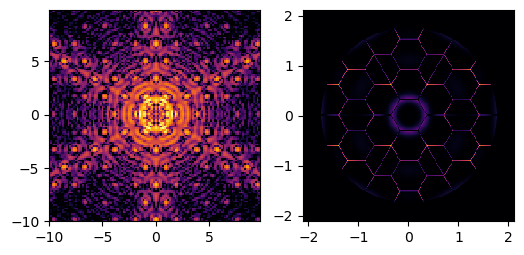

In [13]:
post_lyot_mask = lyot_stop(lyot_plane)
post_lyot_test = lyot_stop(lyot_plane_test)
img = prop(post_lyot_mask).intensity
img_test = prop(post_lyot_test).intensity

plt.subplot(1, 2, 1)
imshow_field(np.log10(img/img.max()), vmin=-4, cmap='inferno')
#plt.colorbar()
#imshow_field(np.log10(img_test/img_test.max()), cmap='inferno')
plt.subplot(1, 2, 2)
imshow_field(post_lyot_mask.intensity, cmap='inferno')
#plt.colorbar()

plt.show()

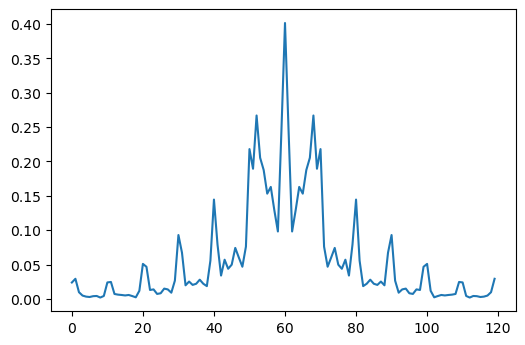

In [14]:
intensity_data = img.shaped
dz = intensity_data[75:120, 75:120]
#plt.imshow(np.log10(dz/np.max(dz)))
#plt.show()
sums = np.sum(intensity_data, axis=1)

plt.plot(np.arange(len(sums)), sums)
plt.show()

In [15]:
def sloppy_spit_out_intensity(fpm_diameter, lyot_diameter):
    telescope_diameter = 4.242
    num_pupil_pixels = 240 #??

    # or do them segments need some aligning?
    pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
    focal_grid = make_focal_grid(6, 10)

    prop = FraunhoferPropagator(pupil_grid, focal_grid)

    iris_aperture = evaluate_supersampled(make_iris_aperture(telescope_diameter), pupil_grid, 6)
    lyot_mask = evaluate_supersampled(circular_aperture(lyot_diameter), pupil_grid, 6)
    fpm_inverse = evaluate_supersampled(circular_aperture(fpm_diameter), pupil_grid, 6)
    t = np.array(fpm_inverse)
    fpm = Field(np.array(t==0, dtype=int), fpm_inverse.grid)
    wavelength = 638e-9 # who knows if this is right?

    wf = hcipy.Wavefront(iris_aperture, wavelength)
    img_ref = prop(wf).intensity
    
    l_coro = LyotCoronagraph(pupil_grid, fpm)
    
    wf = Wavefront(iris_aperture)
    lyot_plane = l_coro(wf)
    
    post_lyot_mask = lyot_stop(lyot_plane)
    img = prop(post_lyot_mask).intensity
    
    intensity_data = img.shaped

    return intensity_data
    

2.0000000000000004 0.2479259063174429


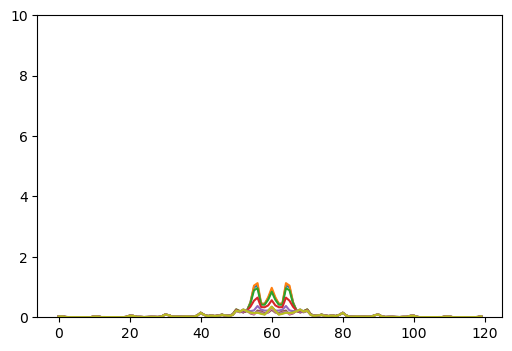

In [16]:
lowest = 10
d = 0
lyot_diameter = 3
fpm_diameter = np.arange(1.5, 2.4, .1)
for fpm_d in fpm_diameter:
    intensity_curve = np.sum(sloppy_spit_out_intensity(fpm_d, lyot_diameter), axis=1)
    if np.max(intensity_curve) < lowest:
        lowest = np.max(intensity_curve)
        d = fpm_d
        
    plt.plot(np.arange(len(intensity_curve)), intensity_curve)
print(d, lowest)
plt.ylim(0,10)
plt.show()

In [ ]:
lowest = 10
d = 0
lyot_diameter = np.arange(2.7, 3.5, .1)
fpm_diameter = 2
for lyot_d in lyot_diameter:
    intensity_curve = np.sum(sloppy_spit_out_intensity(fpm_diameter, lyot_d), axis=1)
    if np.max(intensity_curve) < lowest:
        lowest = np.max(intensity_curve)
        d = lyot_d
        
    plt.plot(np.arange(len(intensity_curve)), intensity_curve)
print(d, lowest)
plt.ylim(0,.5)
plt.show()

In [ ]:
# To Fraunhofer or not to Fraunhofer?

((.0424)**2)/(4*6*10e-9)